In [4]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
# Generate data paths with labels
data_dir =r"C:\Users\DELL\Downloads\archive (32)\lung_colon_image_set"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
df

,filepaths,labels
0,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Adenocarcinoma
1,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Adenocarcinoma
2,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Adenocarcinoma
3,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Adenocarcinoma
4,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Adenocarcinoma
...,...,...
14995,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Squamous Cell Carcinoma
14996,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Squamous Cell Carcinoma
14997,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Squamous Cell Carcinoma
14998,C:\Users\DELL\Downloads\archive (32)\lung_colo...,Lung Squamous Cell Carcinoma


In [7]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [8]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


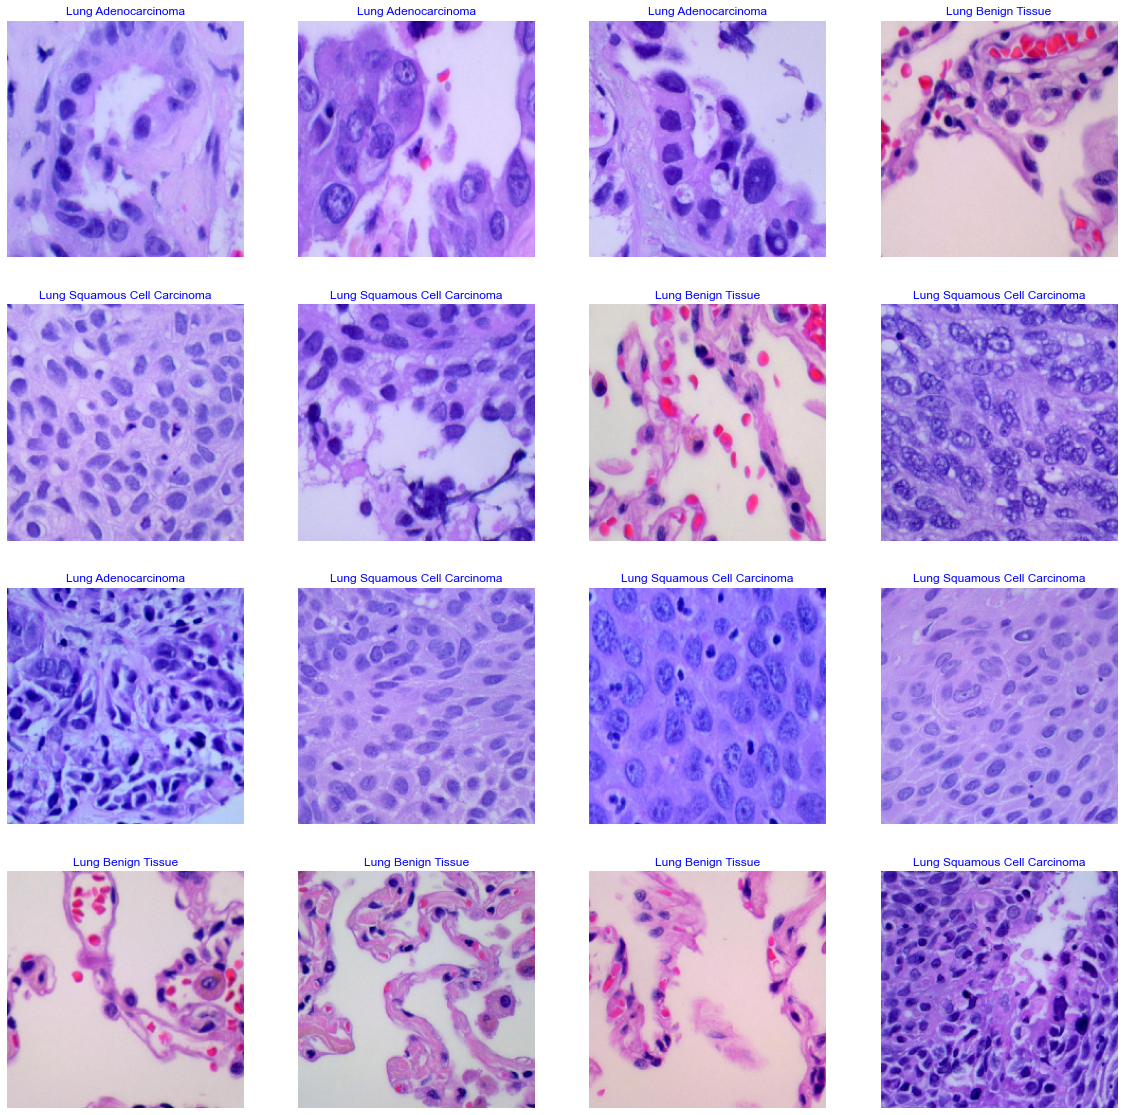

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [11]:
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
188/188 [==============================] - 3783s 20s/step - loss: 2.7155 - accuracy: 0.7523 - val_loss: 0.2531 - val_accuracy: 0.8920
Epoch 2/20
188/188 [==============================] - 4067s 22s/step - loss: 0.2352 - accuracy: 0.9038 - val_loss: 0.2077 - val_accuracy: 0.9053
Epoch 3/20
188/188 [==============================] - 3832s 20s/step - loss: 0.1785 - accuracy: 0.9267 - val_loss: 0.1293 - val_accuracy: 0.9540
Epoch 4/20
188/188 [==============================] - 4055s 22s/step - loss: 0.1388 - accuracy: 0.9452 - val_loss: 0.0986 - val_accuracy: 0.9600
Epoch 5/20
188/188 [==============================] - 3815s 20s/step - loss: 0.1220 - accuracy: 0.9507 - val_loss: 0.1037 - val_accuracy: 0.9560
Epoch 6/20
188/188 [==============================] - 3759s 20s/step - loss: 0.1131 - accuracy: 0.9556 - val_loss: 0.1015 - val_accuracy: 0.9667
Epoch 7/20
188/188 [==============================] - 3748s 20s/step - loss: 0.0917 - accuracy: 0.9638 - val_loss: 0.0645 - val_ac

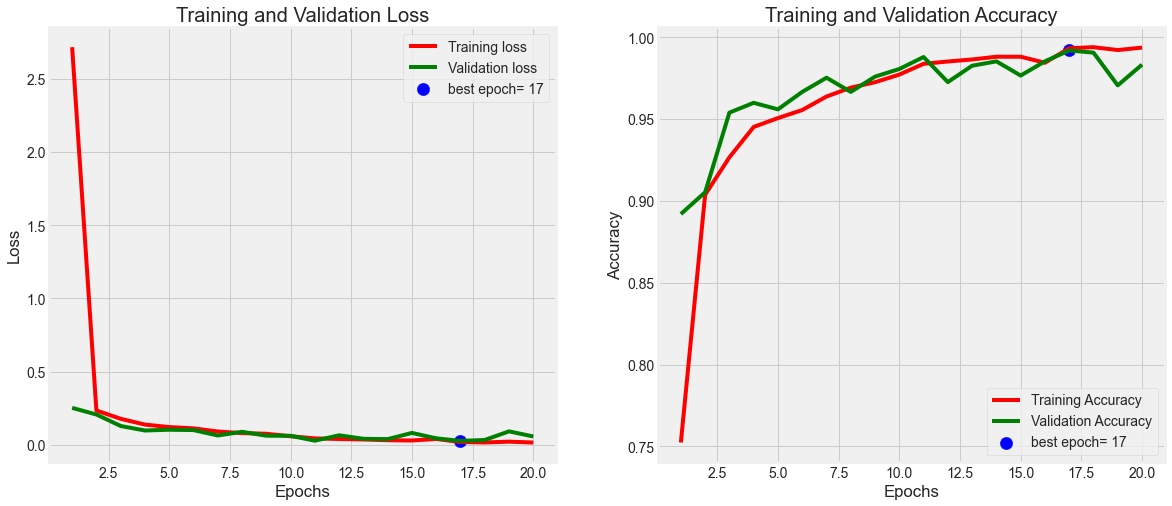

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 92s 5s/step - loss: 0.0552 - accuracy: 0.9820
Train Loss:  0.02334304340183735
Train Accuracy:  0.995312511920929
--------------------
Valid Loss:  0.09127071499824524
Valid Accuracy:  0.9742187261581421
--------------------
Test Loss:  0.055241040885448456
Test Accuracy:  0.9820312261581421


In [20]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [21]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


                              precision    recall  f1-score   support

         Lung Adenocarcinoma       0.97      0.98      0.98       500
          Lung Benign Tissue       0.98      1.00      0.99       500
Lung Squamous Cell Carcinoma       1.00      0.97      0.98       500

                    accuracy                           0.98      1500
                   macro avg       0.98      0.98      0.98      1500
                weighted avg       0.98      0.98      0.98      1500



In [28]:
model.save('lungmodel.h5')

In [23]:
import joblib
joblib.dump(model, 'lungmodel.joblib')


['lungmodel.joblib']

In [24]:
loaded_model = joblib.load('lungmodel.joblib')


In [26]:
import pickle
with open('lungmodel.pkl', 'wb') as f:
    pickle.dump(model, f)


In [27]:
with open('lungmodel.pkl', 'rb') as f:
    loaded_model = pickle.load(f)